### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import random

### Read every cohort study file

In [2]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [3]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [4]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [5]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [6]:
for i in cohort_studies:
    cohort_studies[i]['Age']=cohort_studies_sub[i]['Age']

### Read harmonized mapping tables

In [7]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [8]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [9]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [10]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [11]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [12]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [13]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [14]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [15]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [16]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [17]:
# atn

In [18]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [19]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [20]:
# diag

### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [21]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [22]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [23]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [24]:
cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR'}, inplace=True)

# Plot the CSF biomarkers in different cohorts

In [25]:
# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in atn.index:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma, colo in zip(csf, colors):
# #         print(bioma, csf.index(bioma))
#         sns.histplot(cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
# #         axes[i, csf.index(bioma)].set_title(bioma.upper())
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
#     i+=1
    
# # plt.savefig("csf_biomarkers.png", dpi=300)

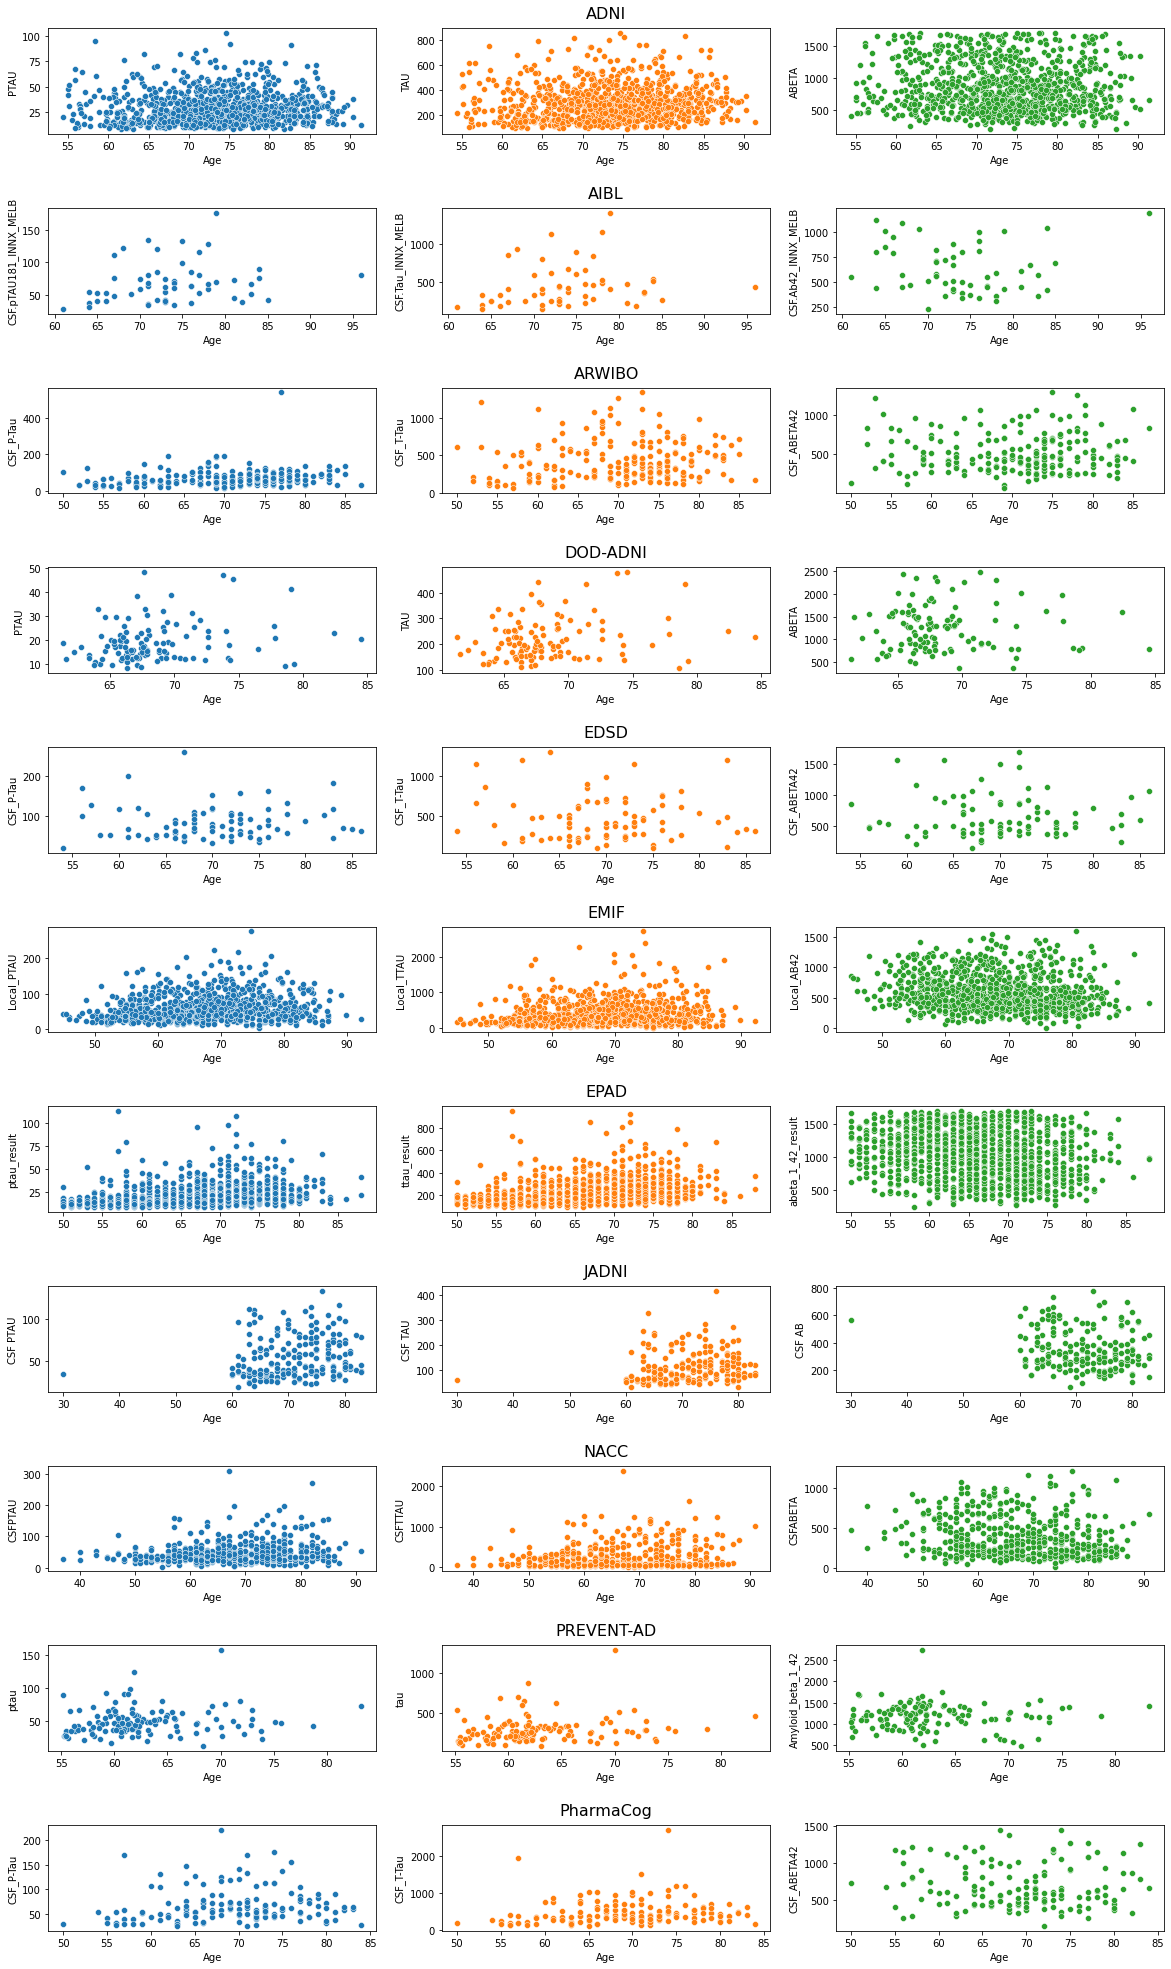

In [26]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, colo in zip(csf, colors):
#         print(bioma, csf.index(bioma))
        sns.scatterplot(x=cohort_studies[ind]['Age'], y=cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
# plt.savefig("csf_biomarkers.png", dpi=300)

### CSF biomarkers, two classes, normal vs abnormal

### subset each cohort dataset based on the columns of interest for clustering 

In [27]:
cohorts_csf = dict()

for i in atn.index:
    
    if len(cohort_studies[i].loc[cohort_studies[i]['Diagnosis']=='CU'].index)>2 and len(cohort_studies[i].loc[cohort_studies[i]['Diagnosis']=='AD'].index)>2:

        csf = mappings['csf'].iloc[:3][i].to_list()

        if i == 'NACC':
            cohorts_csf['NACC_ELISA'] = cohort_studies[i].loc[cohort_studies[i]['CSFTTMD']==1][csf + ["Diagnosis", "Age"]] # ELISA
            cohorts_csf['NACC_XMAP'] = cohort_studies[i].loc[cohort_studies[i]['CSFTTMD']==2][csf + ["Diagnosis", "Age"]] # xmap
            cohorts_csf['NACC_ELISA'] = cohorts_csf['NACC_ELISA'].dropna(subset=cohorts_csf['NACC_ELISA'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
            cohorts_csf['NACC_XMAP'] = cohorts_csf['NACC_XMAP'].dropna(subset=cohorts_csf['NACC_XMAP'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)


        elif i == 'EMIF':
            cohorts_csf['EMIF_ELISA'] = cohort_studies[i].loc[~(cohort_studies[i]['Studyname'].isin(['EDAR', 'Leuven', ]))][csf + ["Diagnosis", "Age"]] # INNOTEST ELISA
            cohorts_csf['EMIF_XMAP'] = cohort_studies[i].loc[(cohort_studies[i]['Studyname'].isin(['EDAR', 'Leuven', ]))][csf + ["Diagnosis", "Age"]] # xmap and not collected
            cohorts_csf['EMIF_ELISA'] = cohorts_csf['EMIF_ELISA'].dropna(subset=cohorts_csf['EMIF_ELISA'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
            cohorts_csf['EMIF_XMAP'] = cohorts_csf['EMIF_XMAP'].dropna(subset=cohorts_csf['EMIF_XMAP'].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)

        else: 
            cohorts_csf[i] = cohort_studies[i][csf + ["Diagnosis", "Age"]]
            cohorts_csf[i] = cohorts_csf[i].dropna(subset=cohorts_csf[i].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)

In [28]:
cohorts_cu_ad = dict()

for i in cohorts_csf:
    cohorts_cu_ad[i] = cohorts_csf[i].loc[(cohorts_csf[i]['Diagnosis']=='CU') | (cohorts_csf[i]['Diagnosis']=='AD')]
    cohorts_cu_ad[i] = cohorts_cu_ad[i].replace({'Diagnosis': {'CU': 0, 'AD': 1}})

### ROC Curve and Youden index
* Use every value in a specific column (e.g. PTAU) as a threshold to classify participants into CU and AD class.

* For every threshold calculate the Youden index.

* Take the threshold that gives the maximum Youden index which indicates the best threshold to discriminate between the two classes.

Youden Index Formula: 

J = sensitivity + specificity − 1

sensitivity = True Positive Rate (TPR)

specificity = 1 - Flase Positive Rate (FPR)

J = TPR + (1 - FPR) - 1

In [29]:
# make an empty dataframe to store the thresholds
cutpointssss = pd.DataFrame(index=cohorts_csf.keys(), columns=mappings['csf'].iloc[:3]['Feature'].to_list())
cutpointssss.columns = ['A-beta 1-42 in CSF', 'pTau in CSF', 'tTau in CSF']

In [32]:
sensitivity_specificity['NACC_ELISA']

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
sensitivity,NaN,NaN,NaN
specificity,NaN,NaN,NaN
youden_index,NaN,NaN,NaN


In [30]:
sensitivity_specificity = {i: pd.DataFrame(index=['sensitivity', 'specificity', 'youden_index'], columns=[cutpointssss.columns]) for i in cutpointssss.index}

In [35]:
cohorts_cu_ad.keys()

dict_keys(['ADNI', 'EMIF_ELISA', 'EMIF_XMAP', 'EPAD', 'JADNI', 'NACC_ELISA', 'NACC_XMAP'])

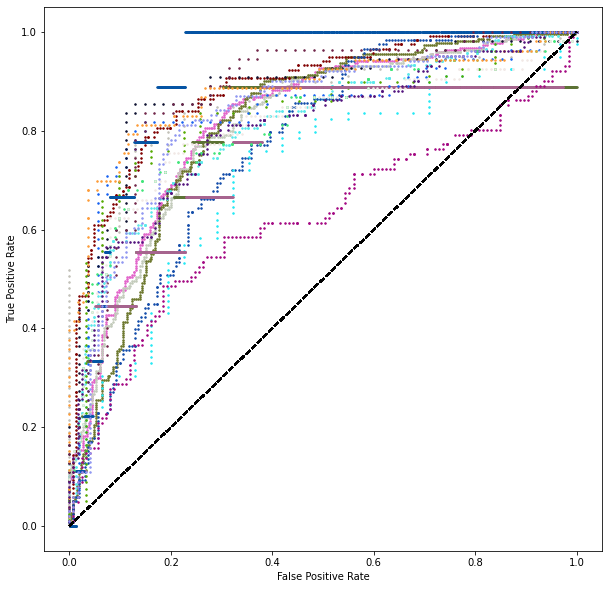

In [37]:
plt.figure(figsize=(10, 10))

for coh_ in cohorts_cu_ad:
    
    if "_" not in coh_:
        biomarkers_ = mappings['csf'].iloc[:3][coh_].to_list()
    #     print(coh_)

        for bio_ in biomarkers_:
            cohorts_cu_ad[coh_] = cohorts_cu_ad[coh_].sort_values(bio_) # sort values based on the column of interest
            youdens = dict() # save all thresholds as key and youden index as value
            sen_spe = dict() # save all sensitivity and specificity values for each threshold
            # generate random color for the plot
            hexadecimal = ["#" + ''.join([random.choice('ABCDEF0123456789') for i in range(6)])]

            bio_mapping = mappings['csf'].loc[mappings['csf'][coh_]==bio_, 'Feature'].item()

            if bio_mapping == 'A-beta 1-42 in CSF':

                for i in cohorts_cu_ad[coh_][bio_].to_list():
                    # classify the participants into CU and AD using a threshold
                    cohorts_cu_ad[coh_].loc[cohorts_cu_ad[coh_][bio_]<i, f'{bio_}' + '_test'] = 1
                    cohorts_cu_ad[coh_].loc[cohorts_cu_ad[coh_][bio_]>=i, f"{bio_}" + '_test'] = 0

                    # calculate the fpr and tpr from ROC curve
                    fpr, tpr, _ = metrics.roc_curve(cohorts_cu_ad[coh_]['Diagnosis'], cohorts_cu_ad[coh_][f"{bio_}"+ '_test'])

                    # plot the ROC curve for visualization purposes
                    plt.plot(fpr[1], tpr[1], color=hexadecimal[0], marker='.', markersize=3)
                    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
                    plt.xlabel("False Positive Rate")
                    plt.ylabel("True Positive Rate")

                    # calculate the specificity
                    specificity = 1 - fpr[1]
                    # calculate the youden index
                    j = tpr[1] + specificity - 1
                    youdens[i] = j
    #                 print(j)

                    # add sensitivity and specificity calculated for each threshold into a dictionary
                    sen_spe[i] = {'sensitivity': tpr[1], 'specificity': specificity}

                # take the threshold that resulted in the maximum youden index
                max_j = max(youdens, key=youdens.get)

                # store threshold in the result df
                cutpointssss.loc[coh_, bio_mapping] = max(youdens, key=youdens.get)

                # store sensitivity and specificity for the chosen threshold
                sensitivity_specificity[coh_].loc['sensitivity', bio_mapping] = round(sen_spe[cutpointssss.loc[coh_, bio_mapping]]['sensitivity'], 2)
                sensitivity_specificity[coh_].loc['specificity', bio_mapping] = round(sen_spe[cutpointssss.loc[coh_, bio_mapping]]['specificity'], 2)
                sensitivity_specificity[coh_].loc['youden_index', bio_mapping] = round(youdens[max_j], 2)

            else:

                for i in cohorts_cu_ad[coh_][bio_].to_list():
                    # classify the participants into CU and AD using a threshold
                    cohorts_cu_ad[coh_].loc[cohorts_cu_ad[coh_][bio_]>i, f'{bio_}' + '_test'] = 1
                    cohorts_cu_ad[coh_].loc[cohorts_cu_ad[coh_][bio_]<=i, f"{bio_}" + '_test'] = 0

                    # calculate the fpr and tpr from ROC curve
                    fpr, tpr, _ = metrics.roc_curve(cohorts_cu_ad[coh_]['Diagnosis'], cohorts_cu_ad[coh_][f"{bio_}"+ '_test'])

                    # plot the ROC curve for visualization purposes
                    plt.plot(fpr[1], tpr[1], color=hexadecimal[0], marker='.', markersize=3)
                    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
                    plt.xlabel("False Positive Rate")
                    plt.ylabel("True Positive Rate")

                    # calculate the specificity
                    specificity = 1 - fpr[1]
                    # calculate the youden index
                    j = tpr[1] + specificity - 1
                    youdens[i] = j

                    # add sensitivity and specificity calculated for each threshold into a dictionary
                    sen_spe[i] = {'sensitivity': tpr[1], 'specificity': specificity}

                # take the threshold that resulted in the maximum youden index
                max_j = max(youdens, key=youdens.get)

                # store threshold in the result df
                cutpointssss.loc[coh_, bio_mapping] = max(youdens, key=youdens.get)

                # store sensitivity and specificity for the chosen threshold
                sensitivity_specificity[coh_].loc['sensitivity', bio_mapping] = round(sen_spe[cutpointssss.loc[coh_, bio_mapping]]['sensitivity'], 2)
                sensitivity_specificity[coh_].loc['specificity', bio_mapping] = round(sen_spe[cutpointssss.loc[coh_, bio_mapping]]['specificity'], 2)
                sensitivity_specificity[coh_].loc['youden_index', bio_mapping] = round(youdens[max_j], 2)

    else:
        
        biomarkers_ = mappings['csf'].iloc[:3][coh_.split("_")[0]].to_list()
#     print(coh_)

        for bio_ in biomarkers_:
            cohorts_cu_ad[coh_] = cohorts_cu_ad[coh_].sort_values(bio_) # sort values based on the column of interest
            youdens = dict() # save all thresholds as key and youden index as value
            sen_spe = dict() # save all sensitivity and specificity values for each threshold
            # generate random color for the plot
            hexadecimal = ["#" + ''.join([random.choice('ABCDEF0123456789') for i in range(6)])]

            bio_mapping = mappings['csf'].loc[mappings['csf'][coh_.split("_")[0]]==bio_, 'Feature'].item()

            if bio_mapping == 'A-beta 1-42 in CSF':

                for i in cohorts_cu_ad[coh_][bio_].to_list():
                    # classify the participants into CU and AD using a threshold
                    cohorts_cu_ad[coh_].loc[cohorts_cu_ad[coh_][bio_]<i, f'{bio_}' + '_test'] = 1
                    cohorts_cu_ad[coh_].loc[cohorts_cu_ad[coh_][bio_]>=i, f"{bio_}" + '_test'] = 0

                    # calculate the fpr and tpr from ROC curve
                    fpr, tpr, _ = metrics.roc_curve(cohorts_cu_ad[coh_]['Diagnosis'], cohorts_cu_ad[coh_][f"{bio_}"+ '_test'])

                    # plot the ROC curve for visualization purposes
                    plt.plot(fpr[1], tpr[1], color=hexadecimal[0], marker='.', markersize=3)
                    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
                    plt.xlabel("False Positive Rate")
                    plt.ylabel("True Positive Rate")

                    # calculate the specificity
                    specificity = 1 - fpr[1]
                    # calculate the youden index
                    j = tpr[1] + specificity - 1
                    youdens[i] = j
    #                 print(j)

                    # add sensitivity and specificity calculated for each threshold into a dictionary
                    sen_spe[i] = {'sensitivity': tpr[1], 'specificity': specificity}

                # take the threshold that resulted in the maximum youden index
                max_j = max(youdens, key=youdens.get)

                # store threshold in the result df
                cutpointssss.loc[coh_, bio_mapping] = max(youdens, key=youdens.get)

                # store sensitivity and specificity for the chosen threshold
                sensitivity_specificity[coh_].loc['sensitivity', bio_mapping] = round(sen_spe[cutpointssss.loc[coh_, bio_mapping]]['sensitivity'], 2)
                sensitivity_specificity[coh_].loc['specificity', bio_mapping] = round(sen_spe[cutpointssss.loc[coh_, bio_mapping]]['specificity'], 2)
                sensitivity_specificity[coh_].loc['youden_index', bio_mapping] = round(youdens[max_j], 2)

            else:

                for i in cohorts_cu_ad[coh_][bio_].to_list():
                    # classify the participants into CU and AD using a threshold
                    cohorts_cu_ad[coh_].loc[cohorts_cu_ad[coh_][bio_]>i, f'{bio_}' + '_test'] = 1
                    cohorts_cu_ad[coh_].loc[cohorts_cu_ad[coh_][bio_]<=i, f"{bio_}" + '_test'] = 0

                    # calculate the fpr and tpr from ROC curve
                    fpr, tpr, _ = metrics.roc_curve(cohorts_cu_ad[coh_]['Diagnosis'], cohorts_cu_ad[coh_][f"{bio_}"+ '_test'])

                    # plot the ROC curve for visualization purposes
                    plt.plot(fpr[1], tpr[1], color=hexadecimal[0], marker='.', markersize=3)
                    plt.plot([0, 1], [0, 1], color="black", linestyle="--")
                    plt.xlabel("False Positive Rate")
                    plt.ylabel("True Positive Rate")

                    # calculate the specificity
                    specificity = 1 - fpr[1]
                    # calculate the youden index
                    j = tpr[1] + specificity - 1
                    youdens[i] = j

                    # add sensitivity and specificity calculated for each threshold into a dictionary
                    sen_spe[i] = {'sensitivity': tpr[1], 'specificity': specificity}

                # take the threshold that resulted in the maximum youden index
                max_j = max(youdens, key=youdens.get)

                # store threshold in the result df
                cutpointssss.loc[coh_, bio_mapping] = max(youdens, key=youdens.get)

                # store sensitivity and specificity for the chosen threshold
                sensitivity_specificity[coh_].loc['sensitivity', bio_mapping] = round(sen_spe[cutpointssss.loc[coh_, bio_mapping]]['sensitivity'], 2)
                sensitivity_specificity[coh_].loc['specificity', bio_mapping] = round(sen_spe[cutpointssss.loc[coh_, bio_mapping]]['specificity'], 2)
                sensitivity_specificity[coh_].loc['youden_index', bio_mapping] = round(youdens[max_j], 2)

In [39]:
sensitivity_specificity['ADNI']

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
sensitivity,0.82,0.8,0.77
specificity,0.7,0.73,0.75
youden_index,0.52,0.54,0.52


In [44]:
cutpointssss = cutpointssss.loc[['ADNI', 'EPAD', 'NACC_ELISA', 'EMIF_ELISA', 'NACC_XMAP', 'EMIF_XMAP', 'JADNI']]

In [45]:
cutpointssss

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
ADNI,801.7,24.25,264.8
EPAD,731.5,20.9,213.8
NACC_ELISA,474.0,64.0,468.0
EMIF_ELISA,560.0,59.0,355.43
NACC_XMAP,226.35,41.18,56.69
EMIF_XMAP,352.2,28.7,100.12
JADNI,333.91,44.86,86.18


In [46]:
cutpointssss.to_csv("../results/cutoffs/roc_cutoffs.csv")

## ATN Profiles

In [47]:
bio_ = list()
for a in ['A', 'T', 'N']: 
    for b in ['+', '-']:
        bio_.append(a+b)
        
profiles_df = pd.DataFrame(index=cutpointssss.index, columns=bio_)

classes = {i: pd.DataFrame(index=cohorts_csf[i].index, columns=['A', 'T', 'N']) for i in cutpointssss.index}
for i in classes: classes[i].replace({np.nan: 0}, inplace=True)

In [48]:
for ind in cutpointssss.index:
    
    if "_" not in ind:

        for col, letter in zip(cutpointssss.columns, ['A', 'T', 'N']):
            threshold = cutpointssss.loc[ind][col]
            bio = mappings['csf'].loc[mappings['csf']['Feature']==col, ind].item()

            if letter == 'T': 
                profiles_df.loc[ind, "T" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                profiles_df.loc[ind, "T" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "T"] = 1
            elif letter == 'N': 
                profiles_df.loc[ind, "N" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                profiles_df.loc[ind, "N" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "N"] = 1
            else: 
                profiles_df.loc[ind, "A" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                profiles_df.loc[ind, "A" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index, "A"] = 1
                
    else:
        
        
        for col, letter in zip(cutpointssss.columns, ['A', 'T', 'N']):
            threshold = cutpointssss.loc[ind][col]
            bio = mappings['csf'].loc[mappings['csf']['Feature']==col, ind.split("_")[0]].item()

            if letter == 'T': 
                profiles_df.loc[ind, "T" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                profiles_df.loc[ind, "T" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "T"] = 1
            elif letter == 'N': 
                profiles_df.loc[ind, "N" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                profiles_df.loc[ind, "N" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "N"] = 1
            else: 
                profiles_df.loc[ind, "A" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
                profiles_df.loc[ind, "A" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
                classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index, "A"] = 1

In [49]:
profiles_df

,A+,A-,T+,T-,N+,N-
ADNI,552,464,524,492,493,523
EPAD,290,946,380,856,475,761
NACC_ELISA,83,121,60,140,83,121
EMIF_ELISA,378,431,384,418,393,417
NACC_XMAP,158,142,100,200,158,142
EMIF_XMAP,102,100,122,80,104,98
JADNI,108,88,106,90,110,86


In [50]:
for i in classes:
    classes[i]['ATN'] = classes[i]['A'].astype(str) + classes[i]['T'].astype(str) + classes[i]['N'].astype(str)

In [56]:
final_profiles = pd.DataFrame(index=classes, columns=list(Counter(classes['ADNI']['ATN']).keys()))
final_profiles.replace({np.nan: 0}, inplace=True)

In [57]:
for i in classes:
    profs = dict(Counter(classes[i]['ATN']))

    for pro in profs:
        final_profiles.loc[i, pro] = profs[pro]

In [58]:
final_profiles.rename(columns={'000': "A-T-N-", '100': 'A+T-N-', '111': 'A+T+N+', '110': 'A+T+N-', 
                               '011': "A-T+N+", '101': "A+T-N+", '001': 'A-T-N+', '010': 'A-T+N-'}, inplace=True)

In [59]:
final_profiles = final_profiles[['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']]

In [60]:
final_profiles.loc['NACC'] = final_profiles.loc['NACC_ELISA'] + final_profiles.loc['NACC_XMAP']
final_profiles.loc['EMIF'] = final_profiles.loc['EMIF_ELISA'] + final_profiles.loc['EMIF_XMAP'] 

In [64]:
final_profiles = final_profiles.loc[['ADNI', 'EPAD', 'NACC', 'EMIF', 'JADNI']]

In [43]:
final_profiles.to_csv("../results/roc/final_profiles_roc.csv")

In [65]:
final_profiles.replace({np.nan:0})

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+
ADNI,304,147,8,6,34,180,1,337
EPAD,639,223,85,0,3,120,13,154
NACC,182,40,32,11,7,65,67,102
EMIF,294,148,39,53,22,148,27,283
JADNI,61,19,9,0,10,16,5,77


### Study-Reported Diagnosis of Patients in each ATN Profile 

In [66]:
cohorts_csf['NACC'] = pd.concat([cohorts_csf['NACC_ELISA'], cohorts_csf['NACC_XMAP']])
cohorts_csf['EMIF'] = pd.concat([cohorts_csf['EMIF_ELISA'], cohorts_csf['EMIF_XMAP']])

classes['NACC'] = pd.concat([classes['NACC_ELISA'], classes['NACC_XMAP']])
classes['EMIF'] = pd.concat([classes['EMIF_ELISA'], classes['EMIF_XMAP']])

In [67]:
for i in ['NACC_ELISA', 'NACC_XMAP', 'EMIF_ELISA', 'EMIF_XMAP']:
    del cohorts_csf[i]

In [68]:
diag_vs_atn = {i: pd.DataFrame(columns=list(Counter(cohorts_csf['ADNI']['Diagnosis'])) + ['Unknown'], index=list(Counter(classes['ADNI']['ATN']))) for i in cohorts_csf}

In [69]:
for coh in cohorts_csf:
    for i in list(Counter(classes[coh]['ATN'])):
        diag_vs_atn[coh].loc[i] = dict(Counter(cohorts_csf[coh].loc[classes[coh].loc[classes[coh]['ATN']==i].index, 'Diagnosis'].replace({np.nan: 'Unknown'})))

In [70]:
for i in diag_vs_atn: 
    diag_vs_atn[i] = diag_vs_atn[i].transpose()
    diag_vs_atn[i].rename(columns={'000': "A-T-N-", '100': 'A+T-N-', '111': 'A+T+N+', '110': 'A+T+N-', 
                               '011': "A-T+N+", '101': "A+T-N+", '001': 'A-T-N+', '010': 'A-T+N-'}, inplace=True)
    diag_vs_atn[i].replace({np.nan: 98989898}, inplace=True)
    diag_vs_atn[i] = diag_vs_atn[i].astype(int)
    diag_vs_atn[i].replace({98989898: '-'}, inplace=True)

In [74]:
for i in diag_vs_atn:
    diag_vs_atn[i] = diag_vs_atn[i][['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']]
    diag_vs_atn[i].to_csv("../results/roc/diag_atn_roc_" + f"{i}" + ".csv")

In [76]:
diag_vs_atn.keys()

dict_keys(['ADNI', 'EPAD', 'JADNI', 'NACC', 'EMIF'])

In [85]:
diag_vs_atn['ADNI']

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+
CU,142,38,3,3,5,50,-,25
MCI,152,82,4,2,20,99,-,172
AD,10,27,1,1,9,31,1,140
Unknown,-,-,-,-,-,-,-,-
